# QCoDeS Example with Lakeshore 325

Here provided is an example session with model 325 of the Lakeshore temperature controller 

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qcodes.instrument_drivers.Lakeshore.Model_325 import Model_325

In [3]:
lake = Model_325("lake", "GPIB0::12::INSTR")

Connected to: LSCI 325 (serial:LSA2251, firmware:1.8/1.1) in 0.15s


## Sensor commands

In [4]:
# Check that the sensor is in the correct status 
lake.sensor_A.status()

'OK'

In [5]:
# What temperature is it reading? 
lake.sensor_A.temperature()

23.102

In [6]:
lake.sensor_A.temperature.unit

'K'

In [7]:
# We can access the sensor objects through the sensor list as well
assert lake.sensor_A is lake.sensor[0]

## Heater commands 

In [8]:
# In a closed loop configuration, heater 1 reads from... 
lake.heater_1.input_channel()

'A'

In [9]:
lake.heater_1.unit()

'Kelvin'

In [10]:
# Get the PID values 
print("P = ", lake.heater_1.P())
print("I = ", lake.heater_1.I())
print("D = ", lake.heater_1.D())

P =  400.0
I =  40.0
D =  10.0


In [11]:
# Is the heater on? 
lake.heater_1.output_range()

'Off'

## Loading and updating sensor calibration values

In [12]:
curve = lake.sensor_A.curve

In [13]:
curve_data = curve.get_data()

In [14]:
curve_data.keys()

dict_keys(['Temperature (K)', 'log Ohm'])

<IPython.core.display.Javascript object>


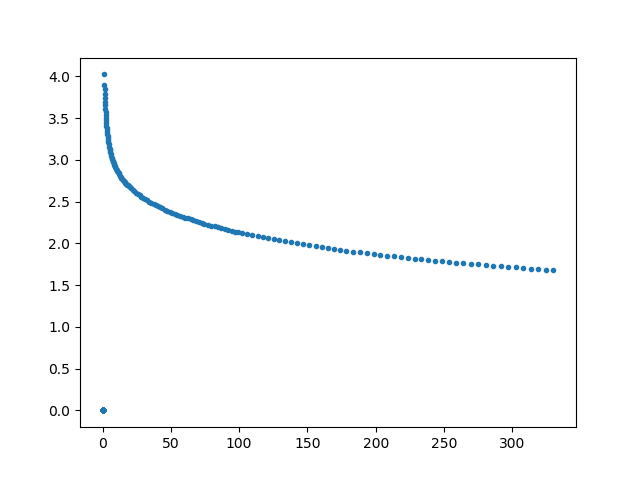

In [15]:
fig, ax = plt.subplots()
ax.plot(curve_data["Temperature (K)"], curve_data['log Ohm'], '.')
plt.show()

In [16]:
curve.curve_name()

'CX-1050-SD-HT-1'

In [17]:
curve_x = lake.curve[23]

In [18]:
curve_x_data = curve_x.get_data()

In [19]:
curve_x_data.keys()

dict_keys(['Temperature (K)', 'log Ohm'])

<IPython.core.display.Javascript object>


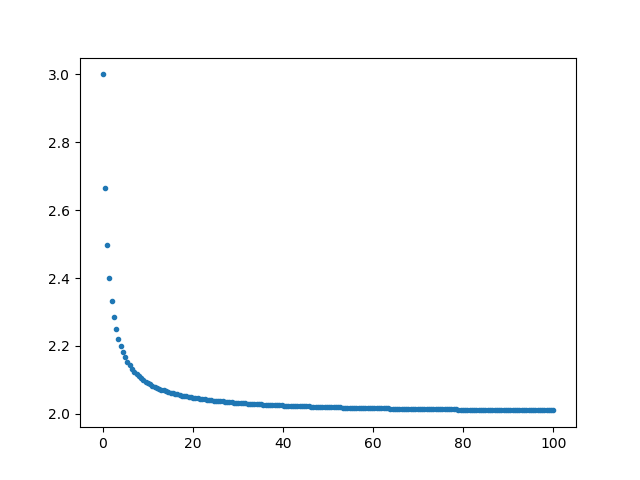

In [20]:
temp = np.linspace(0, 100, 200)
new_data = {"Temperature (K)": temp, "log Ohm": 1/(temp+1)+2}

fig, ax = plt.subplots()
ax.plot(new_data["Temperature (K)"], new_data["log Ohm"], '.')
plt.show()

In [21]:
curve_x.format("log Ohm/K")
curve_x.set_data(new_data)

In [22]:
curve_x.format()

'log Ohm/K'

In [24]:
curve_x_data = curve_x.get_data()

<IPython.core.display.Javascript object>


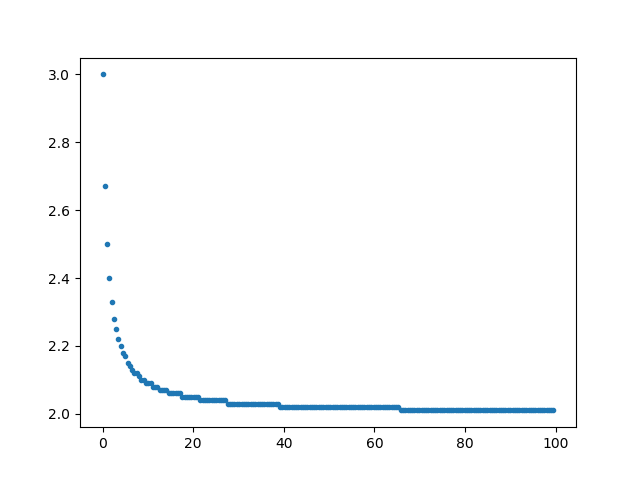

In [25]:
fig, ax = plt.subplots()
ax.plot(curve_x_data["Temperature (K)"], curve_x_data['log Ohm'], '.')
plt.show()

## Go to a set point

In [40]:
import time
import numpy
from IPython.display import display
from ipywidgets import interact, widgets
from matplotlib import pyplot as plt

def live_plot_temperature_reading(channel_to_read, read_period=0.2, n_reads=1000):
    """
    Live plot the temperature reading from a Lakeshore sensor channel
    
    Args:
        channel_to_read
            Lakeshore channel object to read the temperature from
        read_period
            time in seconds between two reads of the temperature
        n_reads
            total number of reads to perform
    """

    # Make a widget for a text display that is contantly being updated
    text = widgets.Text()
    display(text)

    fig, ax = plt.subplots(1)
    line, = ax.plot([], [], '*-')
    ax.set_xlabel('Time, s')
    ax.set_ylabel(f'Temperature, {channel_to_read.temperature.unit}')
    fig.show()
    plt.ion()

    for i in range(n_reads):
        time.sleep(read_period)

        # Update the text field
        text.value = f'T = {channel_to_read.temperature()}'

        # Add new point to the data that is being plotted
        line.set_ydata(numpy.append(line.get_ydata(), channel_to_read.temperature()))
        line.set_xdata(numpy.arange(0, len(line.get_ydata()), 1)*read_period)

        ax.relim()  # Recalculate limits
        ax.autoscale_view(True, True, True)  # Autoscale
        fig.canvas.draw()  # Redraw

Text(value='')

<IPython.core.display.Javascript object>


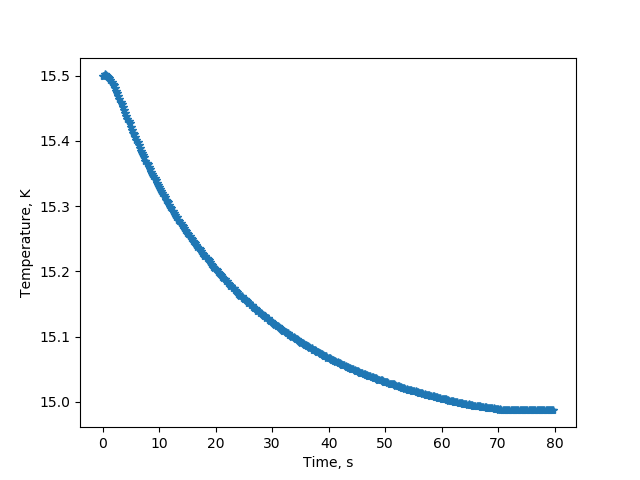

In [9]:
lake.heater_1.control_mode("Manual PID")
lake.heater_1.output_range("Low (2.5W)")
lake.heater_1.input_channel("A")
# The following seem to be good settings for our setup
lake.heater_1.P(400)
lake.heater_1.I(40)
lake.heater_1.D(10)


lake.heater_1.setpoint(15.0)  # <- temperature 
live_plot_temperature_reading(lake.sensor_a, n_reads=400)